Processing BLUELINK dataset...
Closest indices: [2096 5411 7352 4852 2074  129 3291 1834 5947 4827 7646  477 2596 7575
 1102 4513 5420 6337 3025 3142]
Distances to coastline points: [0.08161089 0.06408921 0.02337253 0.0264369  0.05917261 0.05360906
 0.02769115 0.03969595 0.04866021 0.05416999 0.0454831  0.06596275
 0.13980971 0.12468799 0.12777134 0.01309642 0.17489573 0.04580225
 0.09971892 0.21756341]
Saved CEOF results to /DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_BLUELINK.pkl


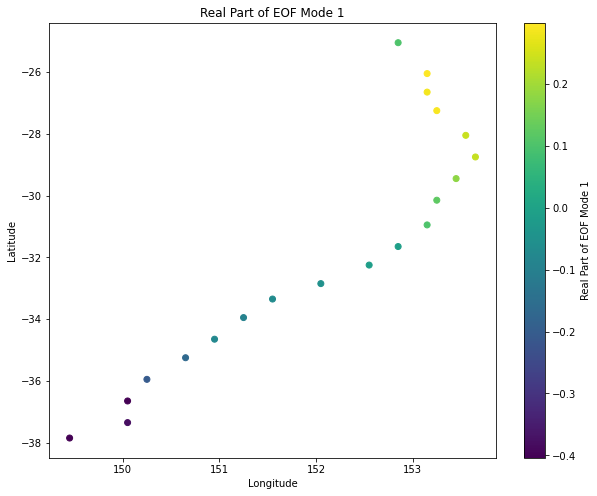

Explained Variance (%) for the first 10 modes:
Mode 1: 72.75%
Mode 2: 17.13%
Mode 3: 4.58%
Mode 4: 2.36%
Mode 5: 1.25%
Mode 6: 0.84%
Mode 7: 0.51%
Mode 8: 0.28%
Mode 9: 0.16%
Mode 10: 0.13%
Processing SWOT dataset...
Closest indices: [ 839 3301 6223 3999 4384 5163 4842 2211 4750 4160 4470 7573 7354 1340
 4812 6318 2323 4199 5051 4959]
Distances to coastline points: [0.03628611 0.04384093 0.071732   0.0493377  0.01692523 0.02555226
 0.04500979 0.03105297 0.03366281 0.02848839 0.0359151  0.02581477
 0.08343061 0.07072417 0.07645391 0.06037208 0.02544583 0.04432285
 0.0644175  0.08101668]
Saved CEOF results to /DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_SWOT.pkl


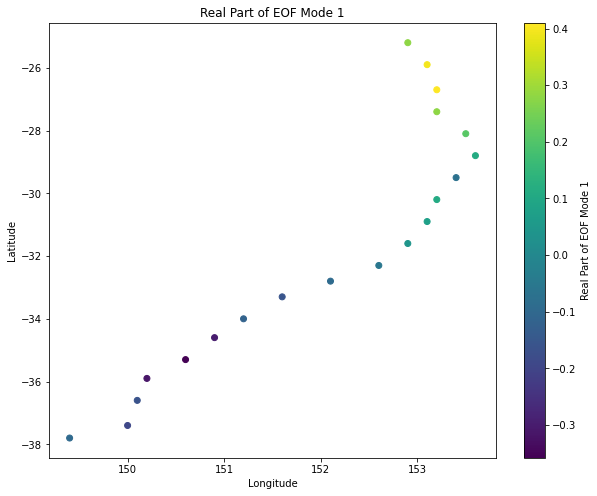

Explained Variance (%) for the first 10 modes:
Mode 1: 35.56%
Mode 2: 23.71%
Mode 3: 10.60%
Mode 4: 9.78%
Mode 5: 7.94%
Mode 6: 4.52%
Mode 7: 3.17%
Mode 8: 2.11%
Mode 9: 1.68%
Mode 10: 0.94%
Processing CMEMS_DT2024 dataset...
Closest indices: [4840  367    0 3719 2143 2276 4104  561 4048 2356 1025 2559 3670 4930
 1040 3713 1464 4662  698 3633]
Distances to coastline points: [0.04065066 0.06701571 0.06330092 0.05499683 0.05794292 0.0747348
 0.05837045 0.0205197  0.0087518  0.01543801 0.07215995 0.03379256
 0.07316623 0.05052073 0.04482096 0.02410857 0.03449411 0.0345135
 0.04586914 0.06203984]
Saved CEOF results to /DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_CMEMS_DT2024.pkl


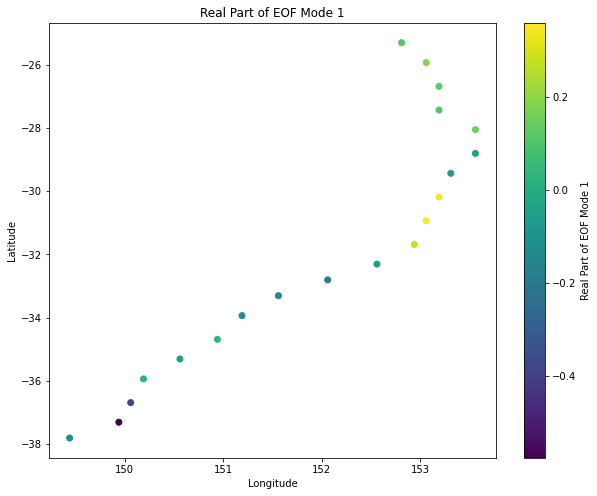

Explained Variance (%) for the first 10 modes:
Mode 1: 42.62%
Mode 2: 18.20%
Mode 3: 12.83%
Mode 4: 9.04%
Mode 5: 6.26%
Mode 6: 4.99%
Mode 7: 3.44%
Mode 8: 1.50%
Mode 9: 0.68%
Mode 10: 0.43%


In [6]:
import numpy as np
from shapely.geometry import Polygon, Point, LineString
import os
import re
import xarray as xr
import matplotlib.pyplot as plt
import pickle
from scipy.spatial import cKDTree
from geopy.distance import geodesic
import cartopy.feature as cfeature

def compute_cumulative_distance(points):
    """Compute cumulative distances from the first point."""
    cumulative_distances = [0]  # Distance from the first point to itself is 0
    for i in range(1, len(points)):
        dist = geodesic((points[i-1][1], points[i-1][0]), (points[i][1], points[i][0])).meters
        cumulative_distances.append(cumulative_distances[-1] + dist)
    return np.array(cumulative_distances)

def extract_coastline(parallelogram, n_points=20):
    """Extract and interpolate equally spaced points along the coastline."""
    coastline = list(cfeature.COASTLINE.geometries())
    coastline_points = []

    for geometry in coastline:
        if geometry.intersects(parallelogram):
            if geometry.geom_type == 'LineString':
                coastline_points.extend(np.array(geometry.coords))
            elif geometry.geom_type == 'MultiLineString':
                for line in geometry:
                    coastline_points.extend(np.array(line.coords))

    coastline_points = np.array(coastline_points)

    # Filter coastline points within the parallelogram
    filtered_points = np.array([point for point in coastline_points if parallelogram.contains(Point(point))])

    # Ensure points are ordered correctly
    if len(filtered_points) > 1:
        first_point = filtered_points[0]
        last_point = filtered_points[-1]
        if last_point[1] < first_point[1] or last_point[0] < first_point[0]:
            filtered_points = filtered_points[::-1]

    # Interpolate equally spaced points along the coastline
    coastline_line = LineString(filtered_points)
    distances = np.linspace(0, coastline_line.length, n_points)
    interpolated_points = np.array([coastline_line.interpolate(d).coords[0] for d in distances])

    return interpolated_points

def find_closest_points(grid_points, coastline_points):
    """Find the closest grid point for each coastline point."""
    tree = cKDTree(grid_points)
    distances, indices = tree.query(coastline_points)
    print(f"Closest indices: {indices}")  # Debug: Print closest indices
    print(f"Distances to coastline points: {distances}")  # Debug: Print distances
    return indices

def get_grid_points_and_files(base_dir):
    """Retrieve grid points and corresponding files from a directory."""
    grid_points = []
    files = os.listdir(base_dir)

    for file in files:
        match = re.search(r"lat_(-?\d+\.\d+)_lon_(-?\d+\.\d+)", file)
        if match:
            lat, lon = map(float, match.groups())
            grid_points.append((lon, lat))

    return np.array(grid_points), files


def create_data_matrix(base_dir, files, grid_points, coastline_points, max_points=100):
    """Create a data matrix by assigning grid points to coastline points."""
    # Find the closest grid point for each coastline point
    closest_indices = find_closest_points(grid_points, coastline_points)

    data_matrix = []
    selected_grid_points = []

    for i in range(min(len(closest_indices), max_points)):
        closest_index = closest_indices[i]
        file_path = os.path.join(base_dir, files[closest_index])

        # Debug: Verify the file path
        if not os.path.exists(file_path):
            print(f"Warning: File does not exist at {file_path}")
            continue

        # Debug: Open the dataset and inspect variables
        try:
            ds = xr.open_dataset(file_path)
            if 'filtered_sla' not in ds.variables:
                print(f"Warning: 'filtered_sla' not found in {file_path}")
                continue

            time_series = ds['filtered_sla'].values
            if time_series.size == 0:
                print(f"Warning: 'filtered_sla' is empty in {file_path}")
                continue

            data_matrix.append(time_series)
            selected_grid_points.append(grid_points[closest_index])
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    if len(data_matrix) == 0:
        print("Warning: Data matrix is empty. Check input files and processing steps.")

    return np.array(data_matrix), np.array(selected_grid_points)


def compute_ceofs(data_matrix, num_modes=10):
    """Compute complex empirical orthogonal functions (CEOFs)."""
    # Subtract the mean to center the data
    data_complex = data_matrix - np.mean(data_matrix, axis=0)

    # Perform Singular Value Decomposition (SVD)
    U, S, Vh = np.linalg.svd(data_complex, full_matrices=False)

    # Retain only the first 'num_modes' modes
    spatial_eofs = U[:, :num_modes]   # Spatial EOFs, shape (num_points, num_modes)
    temporal_pcs = Vh[:num_modes, :]  # Temporal PCs, shape (num_modes, num_time_steps)
    singular_values = S[:num_modes]   # Singular values, shape (num_modes,)

    return spatial_eofs, temporal_pcs, singular_values

def visualize_eof_on_map(spatial_eofs, grid_points, mode=0):
    """Visualize the spatial EOFs on a map."""
    eof_mode = spatial_eofs[:, mode]
    x = grid_points[:, 0]
    y = grid_points[:, 1]
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x, y, c=np.real(eof_mode), cmap='viridis')
    plt.colorbar(scatter, label=f'Real Part of EOF Mode {mode + 1}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Real Part of EOF Mode {mode + 1}')
    plt.show()

def save_ceof_to_pickle(output_dir, dataset_name, spatial_eofs, temporal_pcs, singular_values, grid_points):
    """Save the CEOF results to a pickle file."""
    output_file = os.path.join(output_dir, f"ceof_{dataset_name}.pkl")

    ceof_data = {
        "spatial_eofs": spatial_eofs,
        "temporal_pcs": temporal_pcs,
        "singular_values": singular_values,
        "grid_points": grid_points
    }

    with open(output_file, 'wb') as f:
        pickle.dump(ceof_data, f)

    print(f"Saved CEOF results to {output_file}")

# Define the region of interest
parallelogram_vertices = np.array([
    [149, -38],
    [158, -38],
    [158, -25],
    [149, -25]
])
parallelogram = Polygon(parallelogram_vertices)

# Base directories
base_dirs = {
    "BLUELINK": "/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_BLUELINK",
    "SWOT": "/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT",
    "CMEMS_DT2024": "/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_CMEMS_DT2024"
}

# Output directory
output_dir = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process each dataset
for dataset_name, base_dir in base_dirs.items():
    print(f"Processing {dataset_name} dataset...")

    # Extract equally spaced coastline points
    coastline_points = extract_coastline(parallelogram, n_points=20)

    # Load grid points and corresponding files
    grid_points, files = get_grid_points_and_files(base_dir)

    # Create the data matrix by assigning grid points to coastline points
    data_matrix, selected_grid_points = create_data_matrix(base_dir, files, grid_points, coastline_points, max_points=50)

    # Compute CEOFs and retain only the first 10 modes
    spatial_eofs, temporal_pcs, singular_values = compute_ceofs(data_matrix, num_modes=10)

    # Save to pickle
    save_ceof_to_pickle(output_dir, dataset_name, spatial_eofs, temporal_pcs, singular_values, selected_grid_points)

    # Visualize the first EOF mode on a map
    visualize_eof_on_map(spatial_eofs, selected_grid_points, mode=0)

    # Print explained variance for the first few modes
    explained_variance = (singular_values**2) / np.sum(singular_values**2) * 100
    print("Explained Variance (%) for the first 10 modes:")
    for i, var in enumerate(explained_variance[:10]):
        print(f"Mode {i + 1}: {var:.2f}%")


In [7]:
import pickle

# Define the paths to the saved CEOF files for each dataset
bluelink_ceof_file = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_BLUELINK.pkl"
swot_ceof_file = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_SWOT.pkl"
cmems_ceof_file = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_CMEMS_DT2024.pkl"

# Function to load CEOF data
def load_ceof_data(ceof_file):
    with open(ceof_file, 'rb') as f:
        ceof_data = pickle.load(f)
    return ceof_data

# Load the CEOF data for each dataset
bluelink_ceof_data = load_ceof_data(bluelink_ceof_file)
swot_ceof_data = load_ceof_data(swot_ceof_file)
cmems_ceof_data = load_ceof_data(cmems_ceof_file)

# Extract the first spatial EOF and first temporal PC for each dataset
spatial_eofs_bluelink = bluelink_ceof_data['spatial_eofs']
temporal_pcs_bluelink = bluelink_ceof_data['temporal_pcs']

spatial_eofs_swot = swot_ceof_data['spatial_eofs']
temporal_pcs_swot = swot_ceof_data['temporal_pcs']

spatial_eofs_cmems = cmems_ceof_data['spatial_eofs']
temporal_pcs_cmems = cmems_ceof_data['temporal_pcs']

# Extract the first EOF mode (mode 0) for each dataset
temporal_pcs_1_bluelink = temporal_pcs_bluelink[0, :]
temporal_pcs_1_swot = temporal_pcs_swot[0, :]
temporal_pcs_1_cmems = temporal_pcs_cmems[0, :]


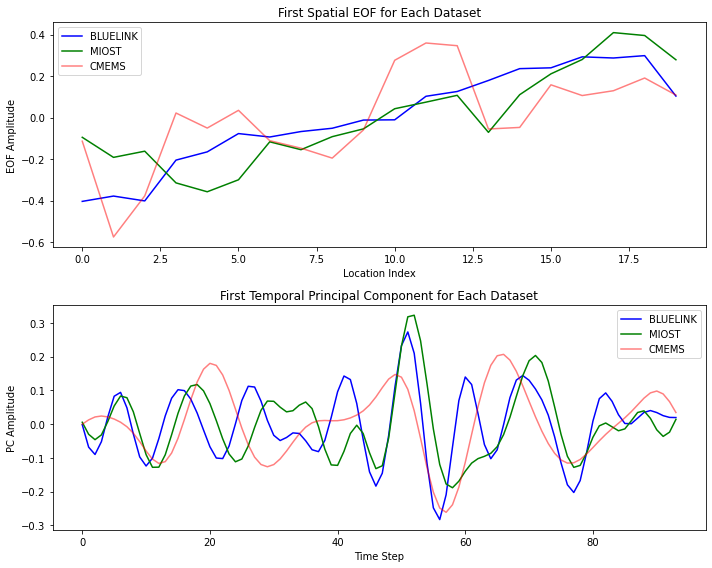

Correlation between BLUELINK and MIOST (Spatial EOF): 0.7816243028191641
Correlation between BLUELINK and CMEMS (Spatial EOF): 0.6792054572538053
Correlation between BLUELINK and MIOST (Temporal PC): 0.5282679735049999
Correlation between BLUELINK and CMEMS (Temporal PC): 0.28841534287116094


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Define the paths to the saved CEOF files for each dataset
bluelink_ceof_file = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_BLUELINK.pkl"
swot_ceof_file = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_SWOT.pkl"
cmems_ceof_file = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_CMEMS_DT2024.pkl"

# Function to load CEOF data
def load_ceof_data(ceof_file):
    with open(ceof_file, 'rb') as f:
        ceof_data = pickle.load(f)
    return ceof_data

# Load the CEOF data for each dataset
bluelink_ceof_data = load_ceof_data(bluelink_ceof_file)
swot_ceof_data = load_ceof_data(swot_ceof_file)
cmems_ceof_data = load_ceof_data(cmems_ceof_file)

# Extract the first spatial EOF and first temporal PC for each dataset
spatial_eofs_bluelink = bluelink_ceof_data['spatial_eofs']  # Shape: (20, 10)
temporal_pcs_bluelink = bluelink_ceof_data['temporal_pcs']  # Shape: (10, T)

spatial_eofs_swot = swot_ceof_data['spatial_eofs']  # Shape: (20, 10)
temporal_pcs_swot = swot_ceof_data['temporal_pcs']  # Shape: (10, T)

spatial_eofs_cmems = cmems_ceof_data['spatial_eofs']  # Shape: (20, 10)
temporal_pcs_cmems = cmems_ceof_data['temporal_pcs']  # Shape: (10, T)

# Extract the first EOF mode (mode 0) for each dataset (spatial component)
spatial_eof_bluelink = spatial_eofs_bluelink[:, 0]
spatial_eof_swot = spatial_eofs_swot[:, 0]
spatial_eof_cmems = spatial_eofs_cmems[:, 0]

# Extract the first temporal PC (mode 0) for each dataset
temporal_pcs_1_bluelink = temporal_pcs_bluelink[0, :]
temporal_pcs_1_swot = temporal_pcs_swot[0, :]
temporal_pcs_1_cmems = temporal_pcs_cmems[0, :]

# Create a figure with 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot: Plot the first spatial EOF for each dataset
axs[0].plot(spatial_eof_bluelink, label='BLUELINK', color='blue')
axs[0].plot(spatial_eof_swot, label='MIOST', color='green')
axs[0].plot(spatial_eof_cmems, label='CMEMS', color='red', alpha=0.5)  # Reduce opacity of red color
axs[0].set_title('First Spatial EOF for Each Dataset')
axs[0].set_xlabel('Location Index')
axs[0].set_ylabel('EOF Amplitude')
axs[0].legend()

# Second subplot: Plot the first temporal PC for each dataset
axs[1].plot(temporal_pcs_1_bluelink, label='BLUELINK', color='blue')
axs[1].plot(temporal_pcs_1_swot, label='MIOST', color='green')
axs[1].plot(temporal_pcs_1_cmems, label='CMEMS', color='red', alpha=0.5)  # Reduce opacity of red color
axs[1].set_title('First Temporal Principal Component for Each Dataset')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('PC Amplitude')
axs[1].legend()

# Save the figure as a .jpg file
save_path = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/plots_for_paper/EOF_PC_comparison.jpg"
plt.savefig(save_path, format='jpg', dpi=300)  # Save with high resolution (dpi=300)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# Compute and print the correlation between the spatial EOFs (first EOF mode)
correlation_spatial_bluelink_swot = np.corrcoef(spatial_eof_bluelink, spatial_eof_swot)[0, 1]
correlation_spatial_bluelink_cmems = np.corrcoef(spatial_eof_bluelink, spatial_eof_cmems)[0, 1]

# Compute and print the correlation between the temporal PCs (first PC mode)
correlation_pc_bluelink_swot = np.corrcoef(temporal_pcs_1_bluelink, temporal_pcs_1_swot)[0, 1]
correlation_pc_bluelink_cmems = np.corrcoef(temporal_pcs_1_bluelink, temporal_pcs_1_cmems)[0, 1]

# Print the correlation values
print(f"Correlation between BLUELINK and MIOST (Spatial EOF): {correlation_spatial_bluelink_swot}")
print(f"Correlation between BLUELINK and CMEMS (Spatial EOF): {correlation_spatial_bluelink_cmems}")
print(f"Correlation between BLUELINK and MIOST (Temporal PC): {correlation_pc_bluelink_swot}")
print(f"Correlation between BLUELINK and CMEMS (Temporal PC): {correlation_pc_bluelink_cmems}")



Saved combined GIF as /DGFI8/H/work_marcello/coastal_trapped_waves_data/combined_EOF_evolution.gif


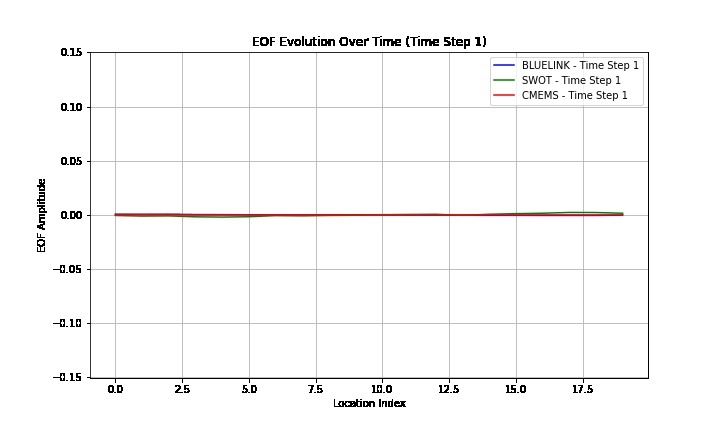

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from IPython.display import Image, display

# Define the output directory for the GIFs
output_dir = "/DGFI8/H/work_marcello/coastal_trapped_waves_data"
os.makedirs(output_dir, exist_ok=True)

# Create GIF for all datasets combined
datasets = {
    "BLUELINK": (spatial_eofs_bluelink[:, 0], temporal_pcs_1_bluelink, 'blue'),
    "SWOT": (spatial_eofs_swot[:, 0], temporal_pcs_1_swot, 'green'),
    "CMEMS": (spatial_eofs_cmems[:, 0], temporal_pcs_1_cmems, 'red')
}

# Directory for temporary frames
temp_frame_dir = os.path.join(output_dir, "frames_combined")
os.makedirs(temp_frame_dir, exist_ok=True)

# List to store frame paths
frames = []

# Precompute global y-limits based on the entire time range
all_scaled_eofs = []
for dataset_name, (spatial_eof, temporal_pc, color) in datasets.items():
    for t in range(len(temporal_pc)):
        scaled_eof = np.real(spatial_eof) * temporal_pc[t]
        all_scaled_eofs.append(scaled_eof)

global_ylim = [-np.max(np.abs(all_scaled_eofs)), np.max(np.abs(all_scaled_eofs))]

# Create GIF for combined datasets
for t in range(len(temporal_pcs_1_bluelink)):  # Assuming same time steps for all datasets
    plt.figure(figsize=(10, 6))
    
    # Plot each dataset at the current time step
    for dataset_name, (spatial_eof, temporal_pc, color) in datasets.items():
        scaled_eof = np.real(spatial_eof) * temporal_pc[t]
        plt.plot(scaled_eof, label=f'{dataset_name} - Time Step {t + 1}', color=color)
    
    # Title and labels
    plt.title(f"EOF Evolution Over Time (Time Step {t + 1})")
    plt.xlabel("Location Index")
    plt.ylabel("EOF Amplitude")
    plt.grid(True)
    
    # Set global y-limits to ensure smooth transitions
    plt.ylim(global_ylim)
    
    # Add legend
    plt.legend()
    
    # Save the frame
    frame_path = os.path.join(temp_frame_dir, f"frame_{t:04d}.png")
    plt.savefig(frame_path)
    frames.append(frame_path)
    plt.close()

# Create the combined GIF
gif_path = os.path.join(output_dir, "combined_EOF_evolution.gif")
with imageio.get_writer(gif_path, mode='I', duration=0.2) as writer:
    for frame_path in frames:
        image = imageio.imread(frame_path)
        writer.append_data(image)

print(f"Saved combined GIF as {gif_path}")

# Display the GIF in the notebook
display(Image(filename=gif_path))

# Clean up temporary frame files (optional)
for frame_path in frames:
    os.remove(frame_path)
os.rmdir(temp_frame_dir)


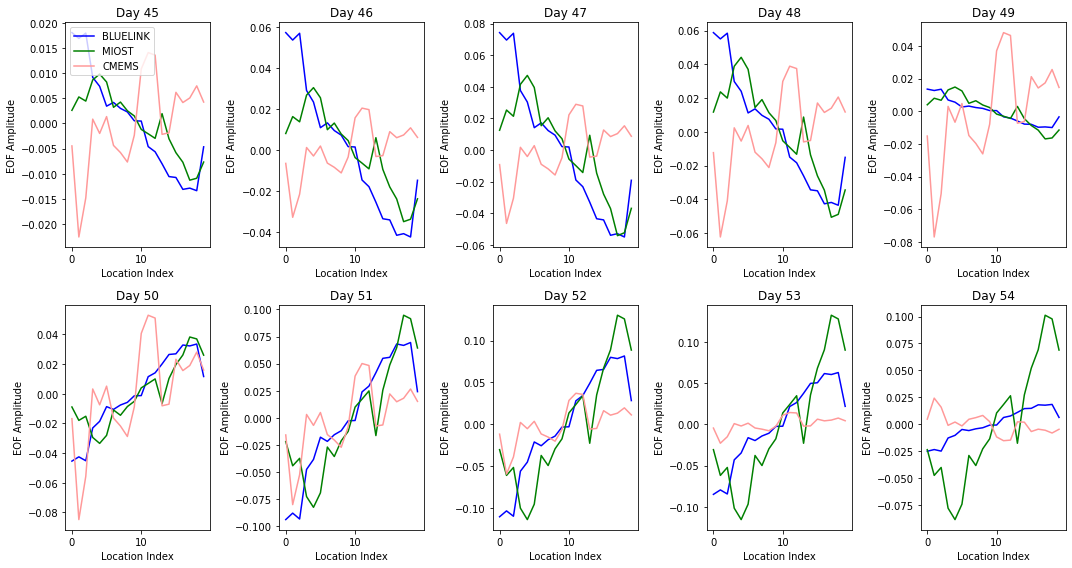

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Define the paths to the saved CEOF files for each dataset
bluelink_ceof_file = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_BLUELINK.pkl"
swot_ceof_file = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_SWOT.pkl"
cmems_ceof_file = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_CMEMS_DT2024.pkl"

# Function to load CEOF data
def load_ceof_data(ceof_file):
    with open(ceof_file, 'rb') as f:
        ceof_data = pickle.load(f)
    return ceof_data

# Load the CEOF data for each dataset
bluelink_ceof_data = load_ceof_data(bluelink_ceof_file)
swot_ceof_data = load_ceof_data(swot_ceof_file)
cmems_ceof_data = load_ceof_data(cmems_ceof_file)

# Extract the first spatial EOF and first temporal PC for each dataset
spatial_eofs_bluelink = bluelink_ceof_data['spatial_eofs']  # Shape: (20, 10)
temporal_pcs_bluelink = bluelink_ceof_data['temporal_pcs']  # Shape: (10, T)

spatial_eofs_swot = swot_ceof_data['spatial_eofs']  # Shape: (20, 10)
temporal_pcs_swot = swot_ceof_data['temporal_pcs']  # Shape: (10, T)

spatial_eofs_cmems = cmems_ceof_data['spatial_eofs']  # Shape: (20, 10)
temporal_pcs_cmems = cmems_ceof_data['temporal_pcs']  # Shape: (10, T)

# Extract the first EOF mode (mode 0) for each dataset (spatial component)
spatial_eof_bluelink = spatial_eofs_bluelink[:, 0]
spatial_eof_swot = spatial_eofs_swot[:, 0]
spatial_eof_cmems = spatial_eofs_cmems[:, 0]

# Extract the first temporal PC (mode 0) for each dataset
temporal_pcs_1_bluelink = temporal_pcs_bluelink[0, :]
temporal_pcs_1_swot = temporal_pcs_swot[0, :]
temporal_pcs_1_cmems = temporal_pcs_cmems[0, :]

# Define the days from 40 to 58, every 2 days
days = np.arange(45, 55, 1)  # Adjusted range to stop at 58

# Create a figure with 10 subplots (2 rows, 5 columns)
fig, axs = plt.subplots(2, 5, figsize=(15, 8))
axs = axs.flatten()  # Flatten the 2D array of axes into a 1D array for easier indexing

# Loop through each subplot to generate the frames for each day
for i, day in enumerate(days):
    day_idx = day - 1  # Assuming the time steps are 1-indexed and match the days directly

    # Compute scaled EOF for the given day
    scaled_eof_bluelink = spatial_eof_bluelink * temporal_pcs_1_bluelink[day_idx]
    scaled_eof_swot = spatial_eof_swot * temporal_pcs_1_swot[day_idx]
    scaled_eof_cmems = spatial_eof_cmems * temporal_pcs_1_cmems[day_idx]

    # Plot the scaled EOF for each dataset in the corresponding subplot
    axs[i].plot(scaled_eof_bluelink, label='BLUELINK', color='blue')
    axs[i].plot(scaled_eof_swot, label='MIOST', color='green')
    axs[i].plot(scaled_eof_cmems, label='CMEMS', color=(1, 0.6, 0.6))  # Lighter red (RGB)

    axs[i].set_title(f'Day {day}')
    axs[i].set_xlabel('Location Index')
    axs[i].set_ylabel('EOF Amplitude')

    # Only add legend to the first subplot (top-left)
    if i == 0:
        axs[i].legend(loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure as a .jpg file
save_path = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/plots_for_paper/EOF_evolution.jpg"
plt.savefig(save_path, format='jpg', dpi=300)

# Display the plot
plt.show()
